# correct the deep @ $\phi_\mu\sim0$ and/or @ $\cos\theta_\mu\sim1$ ?

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load mc and data

In [3]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

found selected_cosmic.csv, loading it...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prod_reco_optfilter_bnb_v12_unblind_mcc8_2018_08_16_selected_on_beam.csv and found the file...
checked /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv and found the file...
9823 selected CC1p events overlay


In [4]:
genie_CC1p['theta_12'] = 180./np.pi*np.arccos((genie_CC1p['truth_Pp_x']*genie_CC1p['truth_Pmu_x']
                                                                   +genie_CC1p['truth_Pp_y']*genie_CC1p['truth_Pmu_y']
                                                                   +genie_CC1p['truth_Pp_z']*genie_CC1p['truth_Pmu_z'])
                                                                  /(genie_CC1p['truth_Pp']*genie_CC1p['truth_Pmu']))
genie_CC1p['Pt'] = np.sqrt(np.square(genie_CC1p['truth_Pp_x']+genie_CC1p['truth_Pmu_x'])
                                               +np.square(genie_CC1p['truth_Pp_y']+genie_CC1p['truth_Pmu_y']))
genie_CC1p['delta_phi'] = 180./np.pi*np.abs(genie_CC1p['truth_Pp_phi']-genie_CC1p['truth_Pmu_phi'])

## cross-section computation

In [5]:
for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
bins1,bins2,bins3 = Bins['Pmu'], Bins['cos(theta(mu))'] , Bins['phi(mu)']
N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1

In [6]:
def compute_Xsec_in_3d(beam_on=None,beam_off=None
                       ,generated_CC1p=None,selected_CC1p=None,overlay=None
                       ,NBins=7
                       ,option=None
                       ,ob_1='Pmu',ob_2='cos(theta(mu))',ob_3='phi(mu)'
                       ,reco_1='reco_Pmu_mcs',reco_2='reco_Pmu_cos_theta',reco_3='reco_Pmu_mcs_phi'
                       ,true_1='truth_Pmu',true_2='truth_Pmu_cos_theta',true_3='truth_Pmu_phi'
                       # for fixing muon bins
                       ,fixed_CC1p=None, fixed_overlay=None
                       ,do_in_kin_cuts=True
                      ):
    # the return is a dictionary of results    
    for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
    global bins1,bins2,bins3,N1,N2,N3
    bins1,bins2,bins3 = Bins[ob_1], Bins[ob_2] , Bins[ob_3]
    N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1
        
    h = dict()
    keys = ['on','off scaled','generated','generated in kin. cuts','CC1p','CC1p scaled','B','eff','eff err'
              ,'Xsec','Xsec err','mc-Xsec','mc-Xsec err','generated-Xsec','generated-Xsec err']
    for key in keys: h[key] = np.zeros((N1,N2,N3))
    N = dict()
    for i_P in range(N1):#{
        Pmin,Pmax = bins1[i_P],bins1[i_P+1]
        P_bin_width = Pmax - Pmin
        for i_cos_theta in range(N2):#{
            cos_theta_min,cos_theta_max = bins2[i_cos_theta],bins2[i_cos_theta+1]
            cos_theta_bin_width = cos_theta_max - cos_theta_min

            for i_phi in range(N3):#{
                phi_min,phi_max = bins3[i_phi],bins3[i_phi+1]
                phi_bin_width = phi_max - phi_min
                
                bin_width = P_bin_width * cos_theta_bin_width * phi_bin_width

                beam_on_in_bin = sam_in_3d_bin(beam_on,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max)
                N['on'] = len(beam_on_in_bin)
                h['on'][i_P][i_cos_theta][i_phi] = N['on']
                
                Xsec_in_bin , Xsec_err_in_bin = 0 , 0
                mc_Xsec_in_bin , mc_Xsec_err_in_bin = 0 , 0
                
                N['off'] = len(sam_in_3d_bin(beam_off,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max))
                N['off scaled'] = N['off']*OffBeam_scaling
                h['off scaled'][i_P][i_cos_theta][i_phi] = N['off scaled']


                N['generated'] = len(sam_in_3d_bin(generated_CC1p,
                                               true_1,Pmin,Pmax,
                                               true_2,cos_theta_min,cos_theta_max,
                                               true_3,phi_min,phi_max))
                N['generated scaled'] = N['generated']*Nevents['f(POT)']
                h['generated'][i_P][i_cos_theta][i_phi] = N['generated']

                delta_theta_12=55  # deg.
                delta_Delta_phi=35 # deg.
                Pt_max=0.35        # GeV/c
                generated_CC1p_in_kin_cuts = generated_CC1p[(np.abs(generated_CC1p['theta_12']-90)<delta_theta_12)                                              
                                                            &(generated_CC1p['Pt']<Pt_max)
                                                            &(np.abs(generated_CC1p['delta_phi']-180.)<delta_Delta_phi)]
                N['generated in kin. cuts'] = len(sam_in_3d_bin(generated_CC1p_in_kin_cuts,
                                                                true_1,Pmin,Pmax,
                                                                true_2,cos_theta_min,cos_theta_max,
                                                                true_3,phi_min,phi_max))
                N['generated in kin. cuts scaled'] = N['generated in kin. cuts']*Nevents['f(POT)']
                h['generated in kin. cuts'][i_P][i_cos_theta][i_phi] = N['generated in kin. cuts']


                N['CC1p'] = len(sam_in_3d_bin(selected_CC1p,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max))
                h['CC1p'][i_P][i_cos_theta][i_phi] = N['CC1p']

                N['CC1p scaled'] = N['CC1p']*Nevents['f(POT)']
                h['CC1p scaled'][i_P][i_cos_theta][i_phi] = N['CC1p scaled']
                
                N['ovrelay'] = len(sam_in_3d_bin(overlay,
                                               reco_1,Pmin,Pmax,
                                               reco_2,cos_theta_min,cos_theta_max,
                                               reco_3,phi_min,phi_max))
                N['ovrelay scaled'] = N['ovrelay']*Nevents['f(POT)']
                
                B, B_err = N['ovrelay scaled'] - N['CC1p scaled'] , np.sqrt(N['ovrelay scaled'] - N['CC1p scaled'])
                h['B'][i_P][i_cos_theta][i_phi] = B

                eff, eff_err = get_eff(Ngen=N['generated'] , Nsel=N['CC1p'])
                if do_in_kin_cuts:
                    eff, eff_err = get_eff(Ngen=N['generated in kin. cuts'] , Nsel=N['CC1p'])
                h['eff'][i_P][i_cos_theta][i_phi] = eff
                h['eff err'][i_P][i_cos_theta][i_phi] = eff_err

                    
                Xsec_in_bin,Xsec_err_in_bin = compute_Xsec(Non=N['on'], Noff=N['off'], B=B, eff=eff, 
                                                               bin_width = bin_width,
                                                               Non_err = np.sqrt(N['on']),
                                                               Noff_err= np.sqrt(N['off']),
                                                               B_err   = B_err,eff_err = eff_err)
                mc_Xsec_in_bin,mc_Xsec_err_in_bin = compute_Xsec(Non=N['CC1p scaled'], eff=eff,
                                                                     bin_width = bin_width,
                                                                     Non_err = np.sqrt(N['CC1p'])*Nevents['f(POT)'],
                                                                     eff_err = eff_err)                
                h['Xsec'][i_P][i_cos_theta][i_phi] = Xsec_in_bin
                h['Xsec err'][i_P][i_cos_theta][i_phi] = Xsec_err_in_bin
                h['mc-Xsec'][i_P][i_cos_theta][i_phi] = mc_Xsec_in_bin
                h['mc-Xsec err'][i_P][i_cos_theta][i_phi] = mc_Xsec_err_in_bin
            #} i_Pmu_phi
        #} i_Pmu_cos_theta
    #} i_Pmu
    print 'done.'  
    return h

In [7]:
def get_Xsec(h = None ,afro_genie_dict=dict(),ylim_P=(0,9),ylim_cos_theta=(0,9),ylim_phi=(0,0.1)
             ,do_add_genie_models=True
             ,ob_1='Pmu',ob_2='cos(theta(mu))',ob_3='phi(mu)'             
             ,true_1='truth_Pmu',true_2='truth_Pmu_cos_theta',true_3='truth_Pmu_phi'
            ):
    get_integrated_Xsec(h=h);
    for gname,ls in zip(['nominal','hA2015','hA_SRC'],['-','--','-.']):
        afro_genie_CC1p = afro_genie_dict[gname]    
        afro_Xsec,afro_Xsec_err = compute_Xsec(Non=len(afro_genie_CC1p), Non_err=np.sqrt(len(afro_genie_CC1p)))
        afro_Xsec,afro_Xsec_err = afro_Xsec*4.908e19/4.9e20,afro_Xsec_err*4.908e19/4.9e20
        print gname,'afro genie Xsec: %.2f ± %.2f'%(afro_Xsec,afro_Xsec_err),'e-39 cm2' 
    fig=plt.figure(figsize=(28,8))
    observable = ob_1
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
    Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N1),np.zeros(N1),np.zeros(N1),np.zeros(N1)
    for i_P in range(N1):#{
        Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
            for i_phi in range(N3):#{
                phi_bin_width = bins3[i_phi+1] - bins3[i_phi]            
                Xsec_1d[i_P] += h['Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
                Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
                mc_Xsec_1d[i_P] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
                mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
            #}
        #}        
        Xsec_1d_err[i_P] = np.sqrt(Xsec_1d_err_sq_sum)
        mc_Xsec_1d_err[i_P] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    #}
    ax = fig.add_subplot(1,3,1)
    ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'])
    #     ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, color='black')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                        , color=Colors['beam on'], capsize=1, capthick=3, label='data')
    if do_add_genie_models:
        for gname,ls in zip(['nominal','hA2015','hA_SRC'],['-','--','-.']):
            h_genie,_ = np.histogram(afro_genie_dict[gname][true_1],bins=bins)
            h_genie_err = np.sqrt(h_genie)
            h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
            genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
            for i in range(len(bins)-1):
                genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,eff=1,eff_err=0,B=0, bin_width=bin_width )
            mystep(x=mid ,dx=bin_width, y=genie_Xsec, y_width=genie_Xsec_err, color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')    
    set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' +r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units)
             ,ylim=ylim_P)
    #-------------------------------
    observable = ob_2
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
    Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N2),np.zeros(N2),np.zeros(N2),np.zeros(N2)
    for i_cos_theta in range(N2):#{
        Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
        for i_P in range(N1):#{
            P_bin_width = bins1[i_P+1] - bins1[i_P]
            for i_phi in range(N3):#{
                phi_bin_width = bins3[i_phi+1] - bins3[i_phi]            
                Xsec_1d[i_cos_theta] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
                Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
                mc_Xsec_1d[i_cos_theta] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
                mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
            #}
        #}        
        Xsec_1d_err[i_cos_theta] = np.sqrt(Xsec_1d_err_sq_sum)
        mc_Xsec_1d_err[i_cos_theta] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    #}
    ax = fig.add_subplot(1,3,2)
    ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'])
    # ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, color='black')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                        , color=Colors['beam on'], capsize=1, capthick=3, label='data')
    if do_add_genie_models:
        for gname,ls in zip(['nominal','hA2015','hA_SRC'],['-','--','-.']):
            h_genie,_ = np.histogram(afro_genie_dict[gname][true_2],bins=bins)
            h_genie_err = np.sqrt(h_genie)
            h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
            genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
            for i in range(len(bins)-1):
                genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,eff=1,eff_err=0,B=0, bin_width=bin_width )
            mystep(x=mid ,dx=bin_width, y=genie_Xsec, y_width=genie_Xsec_err, color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')
    set_axes(ax,xlabel
                 ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                           +r'[$10^{-39}$ cm$^{2}$]'),ylim=ylim_cos_theta)
    # #-------------------------------
    observable = ob_3
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)

    Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N3),np.zeros(N3),np.zeros(N3),np.zeros(N3)
    for i_phi in range(N3):#{
        Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
        for i_P in range(N1):#{
            P_bin_width = bins1[i_P+1] - bins1[i_P]
            for i_cos_theta in range(N2):#{
                cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]            
                Xsec_1d[i_phi] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
                Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
                mc_Xsec_1d[i_phi] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
                mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
            #}
        #}        
        Xsec_1d_err[i_phi] = np.sqrt(Xsec_1d_err_sq_sum)
        mc_Xsec_1d_err[i_phi] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    #}
    ax = fig.add_subplot(1,3,3)
    ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'])
    #ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, color='black')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                        , color=Colors['beam on'], capsize=1, capthick=3, label='data')
    if do_add_genie_models:
        for gname,ls in zip(['nominal','hA2015','hA_SRC'],['-','--','-.']):
            h_genie,_ = np.histogram(180./np.pi*afro_genie_dict[gname][true_3],bins=bins)
            h_genie_err = np.sqrt(h_genie)
            h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
            genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
            for i in range(len(bins)-1):
                genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,eff=1,eff_err=0,B=0, bin_width=bin_width )
            mystep(x=mid ,dx=bin_width, y=genie_Xsec, y_width=genie_Xsec_err, color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')

    set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'+r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units)
             ,do_add_legend=False,ylim=ylim_phi)
    plt.tight_layout()
    print 'done.'

# excluding the bin at $\phi_\mu \sim 0$ 

In [8]:
def modified_sample( sam=None, phi_muon_var='truth_Pmu_phi'):
    '''exclude the bin \phi(µ)~0 bin by removing these events'''
    return sam[( (180./np.pi*sam[phi_muon_var] < Bins['phi(mu)'][(len(Bins['phi(mu)'])-1)/2])                    
                | (180./np.pi*sam[phi_muon_var] > Bins['phi(mu)'][(len(Bins['phi(mu)'])-1)/2+1]))]

modified_beam_on = modified_sample( sam=selected_beam_on, phi_muon_var='reco_Pmu_mcs_phi')
modified_beam_off = modified_sample( sam=selected_beam_off, phi_muon_var='reco_Pmu_mcs_phi')
modified_overlay_genie = modified_sample( sam=genie_CC1p, phi_muon_var='truth_Pmu_phi')
modified_CC1p = modified_sample( sam=selected_CC1p, phi_muon_var='reco_Pmu_mcs_phi')
modified_overlay = modified_sample( sam=selected_overlay_concat, phi_muon_var='reco_Pmu_mcs_phi')

In [9]:
h = compute_Xsec_in_3d(beam_on=modified_beam_on,
                       beam_off=modified_beam_off,                       
                       generated_CC1p=modified_overlay_genie,                       
                       selected_CC1p=modified_CC1p,                       
                       overlay=modified_overlay)

done.


In [11]:
get_Xsec(h = h ,afro_genie_dict=None,do_add_genie_models=False
         ,ylim_P=(0,11),ylim_cos_theta=(0,15),ylim_phi=(0,0.03))

Xsec_integrated: 4.08 +/- 0.32 e-39 cm2
mc_Xsec_integrated: 4.81 +/- 0.09 e-39 cm2


TypeError: 'NoneType' object has no attribute '__getitem__'

In [17]:
h = compute_Xsec_in_3d(beam_on=modified_beam_on,
                       beam_off=modified_beam_off,                       
                       generated_CC1p=modified_overlay_genie,                       
                       selected_CC1p=modified_CC1p,                       
                       overlay=modified_overlay
                       ,ob_1='Pp',ob_2='cos(theta(p))',ob_3='phi(p)'
                       ,reco_1='reco_Pp',reco_2='reco_Pp_cos_theta',reco_3='reco_Pp_phi'
                       ,true_1='truth_Pp',true_2='truth_Pp_cos_theta',true_3='truth_Pp_phi')

done.


Xsec_integrated: 5.04 +/- 0.40 e-39 cm2
mc_Xsec_integrated: 6.16 +/- 0.11 e-39 cm2
nominal afro genie Xsec: 5.56 ± 0.04 e-39 cm2
hA2015 afro genie Xsec: 5.55 ± 0.04 e-39 cm2
hA_SRC afro genie Xsec: 5.02 ± 0.03 e-39 cm2
done.


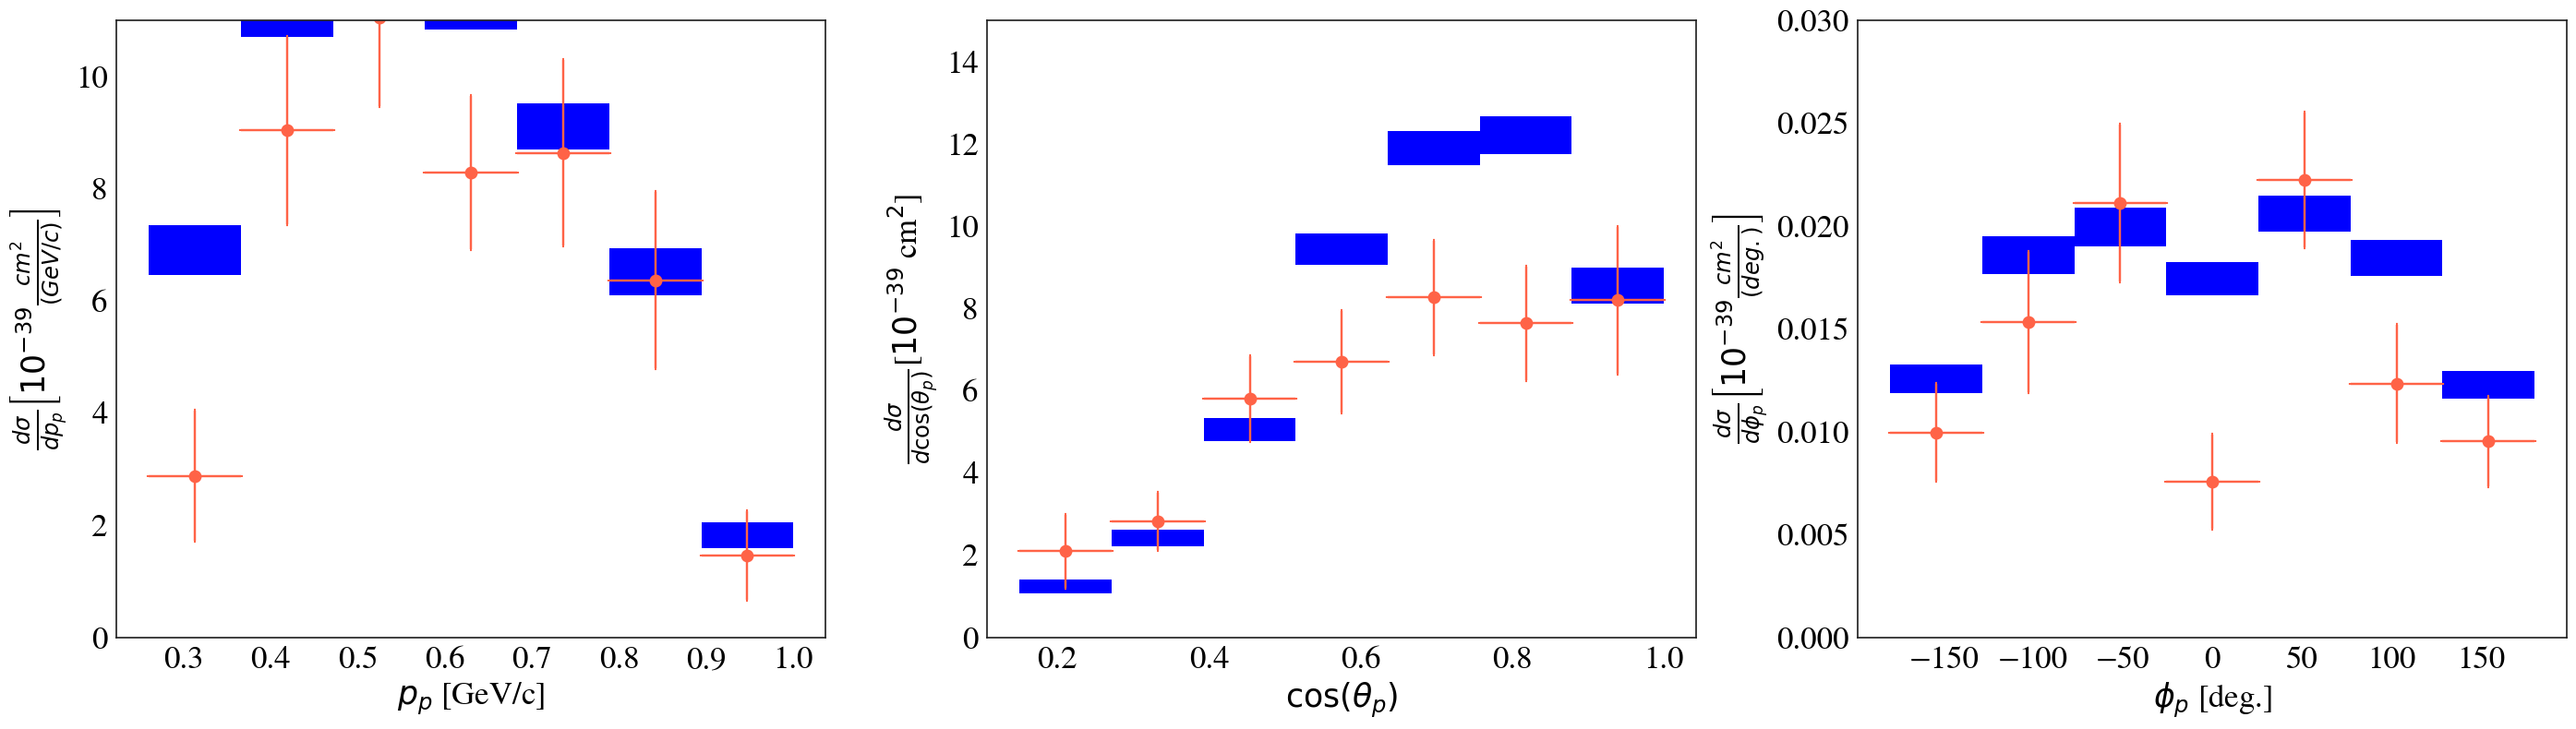

In [18]:
get_Xsec(h = h ,afro_genie_dict=modified_afro_genie,do_add_genie_models=False             
         ,ob_1='Pp',ob_2='cos(theta(p))',ob_3='phi(p)'                      
         ,true_1='truth_Pp',true_2='truth_Pp_cos_theta',true_3='truth_Pp_phi'
         ,ylim_P=(0,11),ylim_cos_theta=(0,15),ylim_phi=(0,0.03))

## divide the sample of events into sub-samples with different muon lengths. Is there a dependency on the track length?

In [29]:
def cut_sample_l_mu( sam=None, l_mu_var='l_muCandidate', l_min=0, l_max=10):
    return sam[(l_min<sam[l_mu_var]) & (sam[l_mu_var]<l_max)]

l_mu_min_array = [0,60,110]
l_mu_max_array = np.concatenate([l_mu_min_array[1:],[10000]])



beam_on_dict = dict()
CC1p_dict = dict()

for l_mu_min,l_mu_max in zip(l_mu_min_array,l_mu_max_array):
    beam_on_dict[l_mu_min] = cut_sample_l_mu( sam=selected_beam_on, l_mu_var='l_muCandidate', l_min=l_mu_min, l_max=l_mu_max)
    CC1p_dict[l_mu_min] = cut_sample_l_mu( sam=selected_CC1p, l_mu_var='l_muCandidate', l_min=l_mu_min, l_max=l_mu_max)

0.730131507978 0.224223435378
0.722756442241 0.168854369901
0.354807708009 0.0746520600655


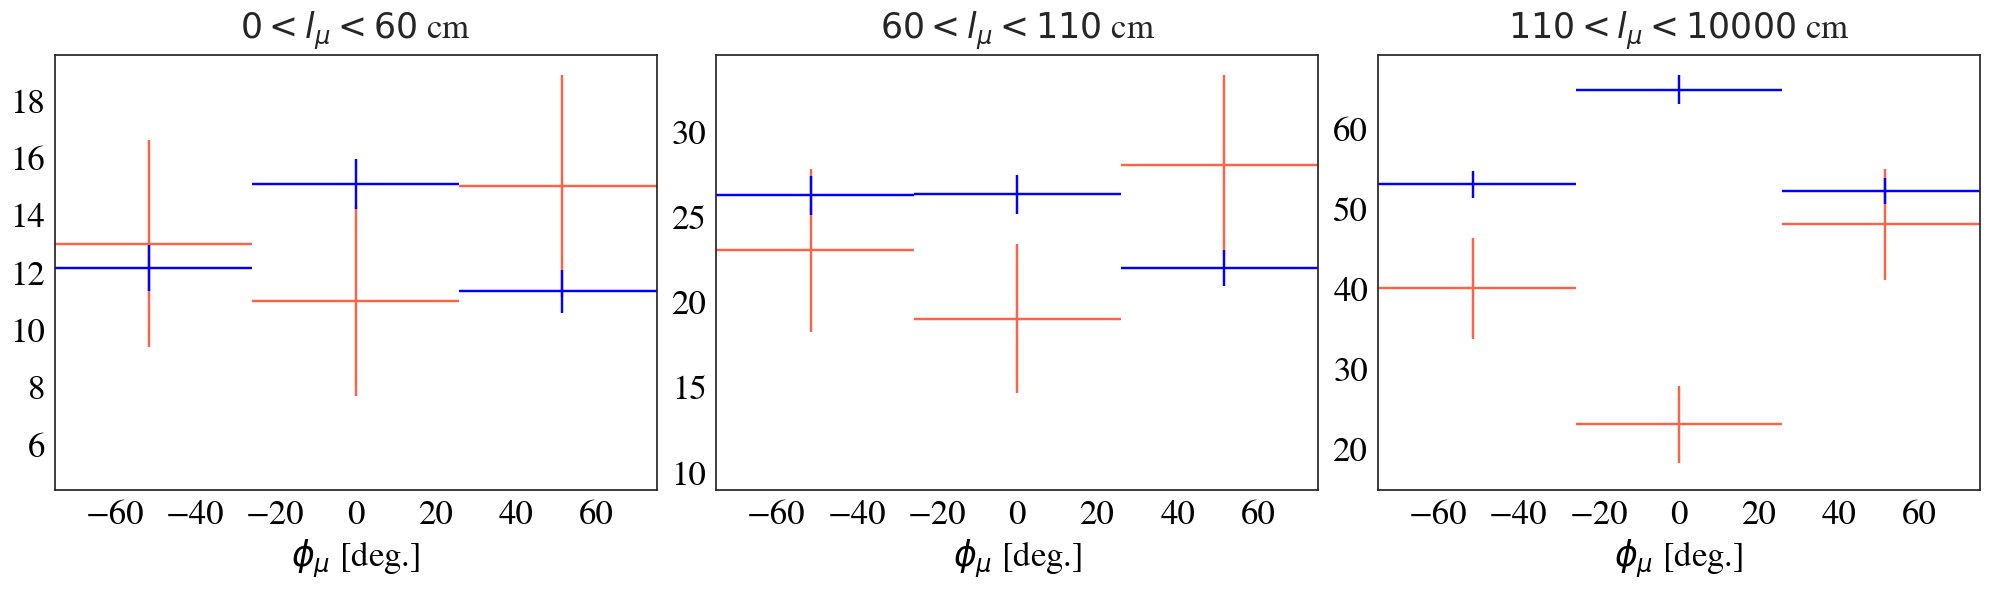

In [30]:
bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable='phi(mu)')
fig=plt.figure(figsize=(20,6))
for iax,(l_mu_min,l_mu_max) in enumerate(zip(l_mu_min_array,l_mu_max_array)):
    ax = fig.add_subplot(1,3,iax+1)
    hist,herr=dict(),dict()
    y,yerr=dict(),dict()
    for sam,slabel,color in zip([beam_on_dict[l_mu_min],CC1p_dict[l_mu_min]]
                                ,['beam-on','mc overlay']
                                ,[Colors['beam on'],Colors['CC1p']]):
        hist[slabel],_ = np.histogram(180./np.pi*sam['reco_Pmu_mcs_phi'],bins=bins)
        herr[slabel] = np.sqrt(hist[slabel])
        y[slabel] = hist[slabel] if slabel=='beam-on' else Nevents['f(POT)']*hist[slabel]
        yerr[slabel] = herr[slabel] if slabel=='beam-on' else Nevents['f(POT)']*herr[slabel]
        plt.errorbar(x=mid,xerr=0.5*bin_width,y=y[slabel],yerr=yerr[slabel],fmt='o',markersize=0,capthick=0,capsize=12,color=color)
    set_axes(ax,xlabel,do_add_legend=True if iax==2 else False
             ,title=r'$%.0f<l_\mu<%.0f$ cm'%(l_mu_min,l_mu_max),xlim=(-75,75))
    
    ratio = (y['beam-on']).astype(np.float)/y['mc overlay']
    ratio_err = ratio*np.sqrt( np.square(yerr['beam-on']/y['beam-on']) + np.square(yerr['mc overlay']/y['mc overlay']))
    print ratio[len(bins)/2-1],ratio_err[len(bins)/2-1]
plt.tight_layout()

In [69]:
np.max(sam['l_pCandidate'])

91.021600000000007

In [74]:
def cut_sample_l_p( sam=None, l_p_var='l_pCandidate', l_min=0, l_max=10):
    return sam[(l_min<sam[l_p_var]) & (sam[l_p_var]<l_max)]

l_p_min_array = [0,10,20,30,40,50]
l_p_max_array = np.concatenate([l_p_min_array[1:],[100]])
l_p_centers = 0.5*(l_p_min_array+l_p_max_array)
l_p_width = 0.5*(l_p_max_array-l_p_min_array)
r_p,r_p_err = [],[]


beam_on_dict = dict()
CC1p_dict = dict()

for l_p_min,l_p_max in zip(l_p_min_array,l_p_max_array):
    beam_on_dict[l_p_min] = cut_sample_l_p( sam=selected_beam_on, l_p_var='l_pCandidate', l_min=l_p_min, l_max=l_p_max)
    CC1p_dict[l_p_min] = cut_sample_l_p( sam=selected_CC1p, l_p_var='l_pCandidate', l_min=l_p_min, l_max=l_p_max)
    
hist,herr=dict(),dict()
y,yerr=dict(),dict()
for iax,(l_p_min,l_p_max) in enumerate(zip(l_p_min_array,l_p_max_array)):
    for sam,slabel,color in zip([beam_on_dict[l_p_min],CC1p_dict[l_p_min]]
                                    ,['beam-on','mc overlay']
                                    ,[Colors['beam on'],Colors['CC1p']]):
        hist[slabel],_ = np.histogram(180./np.pi*sam['reco_Pmu_mcs_phi'],bins=bins)
        herr[slabel] = np.sqrt(hist[slabel])
        y[slabel] = hist[slabel] if slabel=='beam-on' else Nevents['f(POT)']*hist[slabel]
        yerr[slabel] = herr[slabel] if slabel=='beam-on' else Nevents['f(POT)']*herr[slabel]
    ratio= (y['beam-on']).astype(np.float)/y['mc overlay']
    ratio_err = ratio*np.sqrt( np.square(yerr['beam-on']/y['beam-on']) + np.square(yerr['mc overlay']/y['mc overlay']))
    r_p.append(ratio[len(bins)/2-1])
    r_p_err.append(ratio_err[len(bins)/2-1])


def cut_sample_l_mu( sam=None, l_mu_var='l_muCandidate', l_min=0, l_max=10):
    return sam[(l_min<sam[l_mu_var]) & (sam[l_mu_var]<l_max)]

l_mu_min_array = [0,50,90,130,170,300]
l_mu_max_array = np.concatenate([l_mu_min_array[1:],[580]])
l_mu_centers = 0.5*(l_mu_min_array+l_mu_max_array)
l_mu_width = 0.5*(l_mu_max_array-l_mu_min_array)
r_mu,r_mu_err = [],[]

beam_on_dict = dict()
CC1p_dict = dict()

for l_mu_min,l_mu_max in zip(l_mu_min_array,l_mu_max_array):
    beam_on_dict[l_mu_min] = cut_sample_l_mu( sam=selected_beam_on, l_mu_var='l_muCandidate', l_min=l_mu_min, l_max=l_mu_max)
    CC1p_dict[l_mu_min] = cut_sample_l_mu( sam=selected_CC1p, l_mu_var='l_muCandidate', l_min=l_mu_min, l_max=l_mu_max)
    
hist,herr=dict(),dict()
y,yerr=dict(),dict()
for iax,(l_mu_min,l_mu_max) in enumerate(zip(l_mu_min_array,l_mu_max_array)):
    for sam,slabel,color in zip([beam_on_dict[l_mu_min],CC1p_dict[l_mu_min]]
                                    ,['beam-on','mc overlay']
                                    ,[Colors['beam on'],Colors['CC1p']]):
        hist[slabel],_ = np.histogram(180./np.pi*sam['reco_Pmu_mcs_phi'],bins=bins)
        herr[slabel] = np.sqrt(hist[slabel])
        y[slabel] = hist[slabel] if slabel=='beam-on' else Nevents['f(POT)']*hist[slabel]
        yerr[slabel] = herr[slabel] if slabel=='beam-on' else Nevents['f(POT)']*herr[slabel]
    ratio= (y['beam-on']).astype(np.float)/y['mc overlay']
    ratio_err = ratio*np.sqrt( np.square(yerr['beam-on']/y['beam-on']) + np.square(yerr['mc overlay']/y['mc overlay']))
    r_mu.append(ratio[len(bins)/2-1])
    r_mu_err.append(ratio_err[len(bins)/2-1])


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in divide


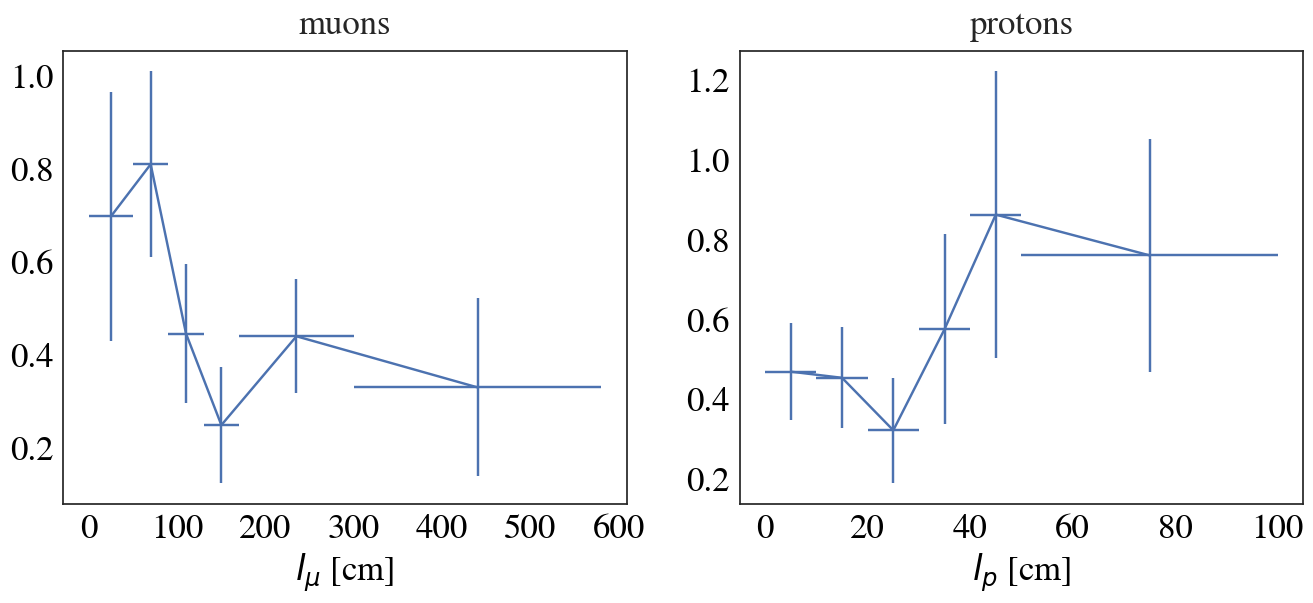

In [76]:
fig=plt.figure(figsize=(16,6))
# ax.bar( x=l_mu_centers , height=2*r_mu_err, bottom=r_mu-r_mu_err, width=l_mu_width, color='blue')
ax=fig.add_subplot(1,2,1)
plt.errorbar(x=l_mu_centers,xerr=l_mu_width,y=r_mu,yerr=r_mu_err)
set_axes(ax,r'$l_\mu$ [cm]',title='muons')
ax=fig.add_subplot(1,2,2)
plt.errorbar(x=l_p_centers,xerr=l_p_width,y=r_p,yerr=r_p_err)
set_axes(ax,r'$l_p$ [cm]',title='protons')